In [1]:
import open3d
import numpy as np

In [27]:
#  create cylinder
cyl = open3d.geometry.PointCloud()
for i in range(4000):
    x = np.random.uniform(0, 0.6) * 2 - 0.6
    y = np.sqrt(0.36 - np.square(x)) * np.random.choice([1, -1], 1)
    z = np.random.uniform(0, 2)
    cyl.points.append([x,y,z])
# cyl_mesh = open3d.geometry.TriangleMesh.create_cylinder(radius=0.2, height=1)
# cyl.points = cyl_mesh.vertices
# cyl.colors = cyl_mesh.vertex_colors
# cyl.normals = cyl_mesh.vertex_normals
cyl.estimate_normals(search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
cyl.orient_normals_towards_camera_location([0, 0, 1])
open3d.visualization.draw_geometries([cyl], point_show_normal=True)

In [3]:
# read chuck
mesh = open3d.io.read_triangle_mesh("../mesh/mesh_i1_n0.4.obj")
pc = open3d.geometry.PointCloud()
pc.points = mesh.vertices
pc.colors = mesh.vertex_colors
pc.normals = mesh.vertex_normals
# R = np.array([[1, 0, 0], [0, np.cos(1.5), -np.sin(1.5)], [0, np.sin(1.5), np.cos(1.5)]])
# pc.rotate(R, [0,0,0])

In [4]:
# normal estimation
downpcd = pc.voxel_down_sample(voxel_size=0.05)
downpcd.estimate_normals(search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
downpcd.normalize_normals()
downpcd.orient_normals_to_align_with_direction([1, 0,0])
open3d.visualization.draw_geometries([downpcd], 
                                  point_show_normal=True)
# print(np.asarray(downpcd.normals))

In [ ]:
print(len(pc.points), len(downpcd.points))

In [33]:
# find KDTree
def KDTree(downpcd):
    downpcd.paint_uniform_color([0.5, 0.5, 0.5])
    pcd_tree = open3d.geometry.KDTreeFlann(downpcd)
    downpcd.colors[100] = [0, 1, 0]
    [k, idx, dist] = pcd_tree.search_radius_vector_3d(downpcd.points[100], 0.6)
    [k2, idx2, dist2] = pcd_tree.search_radius_vector_3d(downpcd.points[100], 0.6/5)
    for i in idx2:
        if i in idx:
            idx.remove(i)
    np.asarray(downpcd.colors)[idx[1:], :] = [1, 0, 0]
    open3d.visualization.draw_geometries([downpcd])
KDTree(cyl)

In [35]:
# pcd_tree = open3d.geometry.KDTreeFlann(cyl)
# [k, idx, dist] = pcd_tree.search_radius_vector_3d(cyl.points[100], 0.6)
# [k2, idx2, dist2] = pcd_tree.search_radius_vector_3d(cyl.points[100], 0.6/5)
# k = k - k2
# idx = idx[k2:]
# dist = dist[k2:]

# open3d.visualization.draw_geometries([cyl])
# w, v, c = ComputeCovariance(cyl, idx)
# cyl.points.append(c)
cyl.paint_uniform_color([0.5, 0.5, 0.5])
cyl.colors[200] = [0, 1, 0]
np.asarray(cyl.colors)[idx[1:], :] = [1, 0, 0]
np.asarray(cyl.colors)[-1, :] = [0, 0, 0]
open3d.visualization.draw_geometries([cyl])

In [52]:
cyl.colors[100] = [0, 1, 0]
[k, idx, dist] = pcd_tree.search_radius_vector_3d(cyl.points[100], 0.6)
patch = open3d.geometry.PointCloud()
idx.append(len(cyl.points)-1)
points = np.asarray(cyl.points)[idx]
colors = np.asarray(cyl.colors)[idx]
patch.points = open3d.utility.Vector3dVector(points)
patch.colors = open3d.utility.Vector3dVector(colors)
open3d.visualization.draw_geometries([patch])
linepoints = [c, c-np.sqrt(w[0])*v[0], c+np.sqrt(w[1])*v[1], c+np.sqrt(w[2])*v[2]]
lines = [[0, 1], [0, 2], [0, 3]]
line_set = open3d.geometry.LineSet(
    points=open3d.utility.Vector3dVector(linepoints),
    lines=open3d.utility.Vector2iVector(lines),
)
open3d.visualization.draw_geometries([patch, line_set])

In [30]:
def ComputeCovariance(demo, idx):
    points = demo
    neighbors = points[idx]
    covariance = np.zeros((3, 3))
    cumulants = np.zeros(9)
    cumulants[:3] = np.mean(neighbors, axis=0)
    dots = neighbors * neighbors
    cumulants[3], cumulants[6], cumulants[8] = np.mean(dots, axis=0)
    cumulants[4] = np.mean(neighbors[:, 0] * neighbors[:, 1])
    cumulants[5] = np.mean(neighbors[:, 0] * neighbors[:, 2])
    cumulants[7] = np.mean(neighbors[:, 1] * neighbors[:, 2])
    
    '''
    for i in range(len(idx)):
        point = demo.points[idx[i]]
        cumulants[0] += point[0]
        cumulants[1] += point[1]
        cumulants[2] += point[2]
        cumulants[3] += point[0] * point[0]
        cumulants[4] += point[0] * point[1]
        cumulants[5] += point[0] * point[2]
        cumulants[6] += point[1] * point[1]
        cumulants[7] += point[1] * point[2]
        cumulants[8] += point[2] * point[2]
    cumulants /= len(idx)
    '''
        
    covariance[0, 0] = cumulants[3]
    covariance[1, 1] = cumulants[6]
    covariance[2, 2] = cumulants[8]
    covariance[0, 1] = cumulants[4]
    covariance[1, 0] = covariance[0, 1]
    covariance[0, 2] = cumulants[5]
    covariance[2, 0] = covariance[0, 2]
    covariance[1, 2] = cumulants[7]
    covariance[2, 1] = covariance[1, 2]
    
    w, v = np.linalg.eig(covariance)
    ind = np.argsort(w, axis=0)
    w = w[ind]
    v = v[:, ind]
    return w, v

def GetDir(demo, r, principle=False):
    pcd_tree = open3d.geometry.KDTreeFlann(demo)
    norms = np.asarray(demo.normals)
    has_norm = demo.has_normals()
    eigenvalues = []
    for i in range(len(demo.points)):
    # for i in [200]:
        # create ring
        [k, idx, dist] = pcd_tree.search_radius_vector_3d(demo.points[i], r)
        # [k2, idx2, dist2] = pcd_tree.search_radius_vector_3d(demo.points[i], r/5)
        # assert idx[k2-1] == idx2[k2-1]
        # k = k - k2
        # idx = idx[k2:]
        # dist = dist[k2:]
        
        if k >= 3:
            w, v = ComputeCovariance(norms, idx)
            if principle:
                #if w[2] < r**2/4 or w[1] < w[2]*2/3:
                if False:
                    normal = [0., 0., 0.]
                else:
                    eigenvalues.append(w)
                    normal = v[:, 0].reshape(3) 
                    if normal[2]<0:
                        normal = -normal
            else:
                normal = v[:, 2].reshape(3)
            if np.linalg.norm(normal) == 0.0:
                normal = [0., 0., 0.]
            if has_norm:
                demo.normals[i] = normal
            else:
                demo.normals.append(normal)
                
        else:
            print(i)
            if has_norm:
                demo.normals[i] = [0., 0., 0.]
            else:
                demo.normals.append([0., 0., 0.])

    if not principle:
        demo.orient_normals_to_align_with_direction([1, 0,0])
    # demo.orient_normals_to_align_with_direction([0, 0, 1])
    open3d.visualization.draw_geometries([demo], point_show_normal=True)
    # print(np.asarray(demo.normals))
    
    return eigenvalues

points = np.asarray(downpcd.points)
xmax, ymax, zmax = np.max(points, axis=0)
xmin, ymin, zmin = np.min(points, axis=0)
center = np.array([(xmax+xmin)/2, (ymax+ymin)/2, (zmax+zmin)/2])
downpcd.estimate_normals(search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
downpcd.orient_normals_towards_camera_location(center)
open3d.visualization.draw_geometries([downpcd], point_show_normal=True)
eigen = GetDir(cyl, 0.6, True)
print(np.array(eigen))

[[2.48316034e-07 5.75223922e-02 9.42477359e-01]
 [1.12003612e-07 6.57001215e-02 9.34299767e-01]
 [2.03920061e-07 7.14399131e-02 9.28559883e-01]
 ...
 [2.96485040e-01 3.39982101e-01 3.63532858e-01]
 [2.81405210e-01 3.39986830e-01 3.78607960e-01]
 [2.95642535e-01 3.19051317e-01 3.85306149e-01]]


In [3]:
def ComputeCovariance(demo, idx):
    points = np.asarray(demo.points)
    neighbors = points[idx]
    covariance = np.zeros((3, 3))
    cumulants = np.zeros(9)
    cumulants[:3] = np.mean(neighbors, axis=0)
    dots = neighbors * neighbors
    cumulants[3], cumulants[6], cumulants[8] = np.mean(dots, axis=0)
    cumulants[4] = np.mean(neighbors[:, 0] * neighbors[:, 1])
    cumulants[5] = np.mean(neighbors[:, 0] * neighbors[:, 2])
    cumulants[7] = np.mean(neighbors[:, 1] * neighbors[:, 2])
    
    '''
    for i in range(len(idx)):
        point = demo.points[idx[i]]
        cumulants[0] += point[0]
        cumulants[1] += point[1]
        cumulants[2] += point[2]
        cumulants[3] += point[0] * point[0]
        cumulants[4] += point[0] * point[1]
        cumulants[5] += point[0] * point[2]
        cumulants[6] += point[1] * point[1]
        cumulants[7] += point[1] * point[2]
        cumulants[8] += point[2] * point[2]
    cumulants /= len(idx)
    '''
        
    covariance[0, 0] = cumulants[3] - cumulants[0] * cumulants[0]
    covariance[1, 1] = cumulants[6] - cumulants[1] * cumulants[1]
    covariance[2, 2] = cumulants[8] - cumulants[2] * cumulants[2]
    covariance[0, 1] = cumulants[4] - cumulants[0] * cumulants[1]
    covariance[1, 0] = covariance[0, 1]
    covariance[0, 2] = cumulants[5] - cumulants[0] * cumulants[2] 
    covariance[2, 0] = covariance[0, 2]
    covariance[1, 2] = cumulants[7] - cumulants[1] * cumulants[2] 
    covariance[2, 1] = covariance[1, 2]
    
    w, v = np.linalg.eig(covariance)
    ind = np.argsort(w, axis=0)
    w = w[ind]
    v = v[:, ind]
    return w, v

def ComputeCovarianceDist(demo, idx, dists, h=0.2):
    assert len(idx) == len(dists)
    covariance = np.zeros((3, 3))
    cumulants = np.zeros(10)
    for i in range(len(idx)):
        point = demo.points[idx[i]]
        d = np.exp(-dists[i] / np.square(h))
        cumulants[0] += point[0] * d # Ex
        cumulants[1] += point[1] * d # Ey
        cumulants[2] += point[2] * d # Ez
        cumulants[3] += point[0] * point[0] * d # Ex^2d
        cumulants[4] += point[0] * point[1] * d # Exyd
        cumulants[5] += point[0] * point[2] * d # Exzd
        cumulants[6] += point[1] * point[1] * d # Ey^2d
        cumulants[7] += point[1] * point[2] * d # Eyzd
        cumulants[8] += point[2] * point[2] * d # Ez^2d
        cumulants[9] += d
        
    # cumulants /= len(idx)
    covariance[0, 0] = cumulants[3] + cumulants[0] * cumulants[0] * (cumulants[9] - 2)
    covariance[1, 1] = cumulants[6] + cumulants[1] * cumulants[1] * (cumulants[9] - 2)
    covariance[2, 2] = cumulants[8] + cumulants[2] * cumulants[2] * (cumulants[9] - 2)
    covariance[0, 1] = cumulants[4] + cumulants[0] * cumulants[1] * (cumulants[9] - 2)
    covariance[1, 0] = covariance[0, 1]
    covariance[0, 2] = cumulants[5] + cumulants[0] * cumulants[2] * (cumulants[9] - 2)
    covariance[2, 0] = covariance[0, 2]
    covariance[1, 2] = cumulants[7] + cumulants[1] * cumulants[2] * (cumulants[9] - 2)
    covariance[2, 1] = covariance[1, 2]
    
    w, v = np.linalg.eig(covariance)
    ind = np.argsort(w, axis=0)
    w = w[ind]
    v = v[:, ind]
    return w, v

In [4]:
def GetDir(demo, r, principle=False):
    pcd_tree = open3d.geometry.KDTreeFlann(demo)
    has_norm = demo.has_normals()
    eigenvalues = []
    for i in range(len(demo.points)):
    # for i in [200]:
        # create ring
        [k, idx, dist] = pcd_tree.search_radius_vector_3d(demo.points[i], r)
        [k2, idx2, dist2] = pcd_tree.search_radius_vector_3d(demo.points[i], r/5)
        assert idx[k2-1] == idx2[k2-1]
        k = k - k2
        idx = idx[k2:]
        dist = dist[k2:]
        
        if k >= 3:
            w, v = ComputeCovariance(demo, idx)
            if principle:
                if w[2] < r**2/4 or w[1] < w[2]*2/3:
                # if False:
                    normal = [0., 0., 0.]
                else:
                    eigenvalues.append(w)
                    normal = v[:, 2].reshape(3) 
                    if normal[2]<0:
                        normal = -normal
            else:
                normal = v[:, 0].reshape(3)
            if np.linalg.norm(normal) == 0.0:
                normal = [0., 0., 0.]
            if has_norm:
                demo.normals[i] = normal
            else:
                demo.normals.append(normal)
                
        else:
            print(i)
            if has_norm:
                demo.normals[i] = [0., 0., 0.]
            else:
                demo.normals.append([0., 0., 0.])

    if not principle:
        demo.orient_normals_to_align_with_direction([1, 0,0])
    # demo.orient_normals_to_align_with_direction([0, 0, 1])
    open3d.visualization.draw_geometries([demo], point_show_normal=True)
    # print(np.asarray(demo.normals))
    
    return eigenvalues
    
eigen = GetDir(cyl, 0.6, True)
print(np.array(eigen))

[[0.00434153 0.07132961 0.09596876]
 [0.00453709 0.0704519  0.09792212]
 [0.00494563 0.07162903 0.09223975]
 ...
 [0.00486034 0.07038946 0.10001967]
 [0.00482239 0.0706563  0.09748615]
 [0.0049012  0.07531479 0.09240862]]


In [ ]:
order = np.argsort(np.asarray(np.array(eigen))[:, 2])
sortedpoints = np.array(eigen)[order]
print(sortedpoints)
print(sortedpoints.shape)

In [ ]:
open3d.visualization.draw_geometries([downpcd], point_show_normal=True)

In [ ]:
open3d.visualization.draw_geometries([cyl], point_show_normal=True)

In [ ]:
# cyl ave direction
norms = open3d.geometry.PointCloud()
norms.points = cyl.normals
open3d.visualization.draw_geometries([norms])
ave = np.average(np.asarray(cyl.normals), axis=0)
print(ave)

In [ ]:
# chuck ave direction
norms = open3d.geometry.PointCloud()
for n in downpcd.normals:
    if np.linalg.norm(n) != 0.0:
        norms.points.append(n)
open3d.visualization.draw_geometries([norms])
ave = np.average(np.asarray(norms.points), axis=0)
print(ave)

In [31]:
from scipy import stats
def FindDir(demo):
    norms = open3d.geometry.PointCloud()
    for n in demo.normals:
        if np.linalg.norm(n) != 0.0:
            norms.points.append(n)
    norms.paint_uniform_color([0.5, 0.5, 0.5])
    open3d.visualization.draw_geometries([norms])
    initials = np.asarray(norms.points)
    goods = np.ones(initials.shape[0]).astype(bool)
    index = np.where(goods>0)
    ave = np.average(initials[goods, :], axis=0)
    ave = ave / np.linalg.norm(ave)
    print(ave)
    ratio = 2
    for i in range(5):
        z = np.abs(stats.zscore(initials[goods, :], axis=0))
        goods[index] = (z < 2).all(axis=1)
        index  = np.where(goods)
        norms.paint_uniform_color([0.5, 0.5, 0.5])
        np.asarray(norms.colors)[goods, :] = [1, 0, 0]
        ave = np.average(initials[goods, :], axis=0)
        ave = ave / np.linalg.norm(ave)
        open3d.visualization.draw_geometries([norms])
        print(ave)
    return ave
        
ave = FindDir(cyl)

[-0.00942776  0.06158376  0.99805739]
[-0.00942776  0.06158376  0.99805739]
[-0.00942776  0.06158376  0.99805739]
[-0.00942776  0.06158376  0.99805739]
[-0.00942776  0.06158376  0.99805739]
[-0.00942776  0.06158376  0.99805739]


In [19]:
# print centerline
# center = np.average(np.asarray(downpcd.points), axis=0)
points = np.asarray(downpcd.points)
xmax, ymax, zmax = np.max(points, axis=0)
xmin, ymin, zmin = np.min(points, axis=0)
center = np.array([(xmax+xmin)/2, (ymax+ymin)/2, (zmax+zmin)/2])
linepoints = [center-ave*3, center+ave*3]
lines = [[0, 1]]
line_set = open3d.geometry.LineSet(
    points=open3d.utility.Vector3dVector(linepoints),
    lines=open3d.utility.Vector2iVector(lines),
)
open3d.visualization.draw_geometries([downpcd, line_set])

In [ ]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

thetas = np.zeros((len(downpcd.normals), 3))
corr = open3d.geometry.PointCloud()
for i in range(len(downpcd.normals)):
    theta = cart2sph(downpcd.normals[i][0], downpcd.normals[i][1], downpcd.normals[i][2])
    thetas[i, :] = theta
    corr.points.append(theta)
open3d.visualization.draw_geometries([corr])

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(thetas[:, 0], thetas[:, 1], marker='.')
plt.show()

In [ ]:
order = np.argsort(points[:, 2])
sortedpoints = points[order]

In [20]:
direction = ave / np.linalg.norm(ave)
print(direction)
ori_dire = [0, -direction[2], direction[1]]
ori_dire = ori_dire / np.linalg.norm(ori_dire)

allpoints = np.asarray(pc.points)
vpc = allpoints - center
projected_l = np.dot(vpc, direction).reshape(-1, 1)
projected_p = center + projected_l * direction
vpr = allpoints - projected_p
r = np.linalg.norm(vpr, axis=1).reshape(-1, 1)
vpr = vpr / r
cos_theta = np.dot(vpr, ori_dire)
cos_theta = np.minimum(1, np.maximum(cos_theta, -1))
theta = np.arccos(cos_theta)
theta[vpr[:,0] < 0] *= -1
theta[vpr[:,0] < 0] += 2 * np.pi

[-0.04788762  0.0264594   0.99850222]


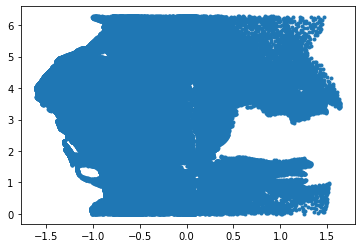

0.5575077088591044


In [21]:
import matplotlib.pyplot as plt
plt.scatter(projected_l, theta, marker='.')
plt.show()
print(np.mean(r))